## Import Packages

In [1]:
import os
import yaml

import pandas as pd
import numpy as np
import scanpy as sc
import scipy.io

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

## Parameters

In [3]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1973_HD1915_7xNK_FB_HTO"
workflow_id = "c3a941bf-62ed-469e-8ee6-d7448cdee457"
path_data = os.path.join("./hashtag/", sample_name, workflow_id)

## Load AnnData

In [4]:
adata = sc.read_h5ad(os.path.join(path_data, f"{sample_name}.h5ad"))

In [5]:
adata

AnnData object with n_obs × n_vars = 10957 × 7
    obs: 'unmapped', 'barcode_sequence', 'hash_id'
    var: 'feature_name'

In [6]:
adata.obs

,unmapped,barcode_sequence,hash_id
227303201131438,27,CTGTGAACATCAGCGC,Doublet
191766864546027,16,GTACAACTCGCAATGT,A0252
227434332055453,7,CTGGACGCAAACTCTG,A0256
133921842280299,14,TCTACATTCGATTGGT,A0255
165239984667435,21,AGAAATGCAGGTGAGT,A0257
...,...,...,...
197281467784107,24,GACCCAGTCTGGGCGT,A0251
205861516597556,13,GCCTGTTCAATGAACA,A0251
196576840146219,30,GAGAAATAGCAGCAGT,Doublet
162072265964956,17,AACCTGATCGCTCCTA,A0257


In [7]:
adata.var

,feature_name
A0251-GTCAACTCTTTAGCG,CD56brightA+C-
A0252-TGATGGCCTATTGGG,CD56brightA+C+
A0253-TTCCGCCTCTCTTTG,CD56dimA+C+
A0254-AGTAAGTTCAGCGTA,CD56dimA+C-
A0255-AAGTATCGTTTCGCA,CD56dimA-C+NKp30hi
A0256-GGTTGCCAGATGTCA,CD56dimA-C+NKp30-
A0257-TGTCTTTCCTGCCAG,CD56dimA-C-


## Total UMIs

In [8]:
# total UMIs per cell barcode
adata.obs["total_umis"] = adata.X.sum(axis=1).A1

In [9]:
adata.obs

,unmapped,barcode_sequence,hash_id,total_umis
227303201131438,27,CTGTGAACATCAGCGC,Doublet,749
191766864546027,16,GTACAACTCGCAATGT,A0252,539
227434332055453,7,CTGGACGCAAACTCTG,A0256,237
133921842280299,14,TCTACATTCGATTGGT,A0255,492
165239984667435,21,AGAAATGCAGGTGAGT,A0257,615
...,...,...,...,...
197281467784107,24,GACCCAGTCTGGGCGT,A0251,433
205861516597556,13,GCCTGTTCAATGAACA,A0251,334
196576840146219,30,GAGAAATAGCAGCAGT,Doublet,627
162072265964956,17,AACCTGATCGCTCCTA,A0257,477


In [10]:
# sort by total umi in descending order
adata_sorted = adata[adata.obs.sort_values(by="total_umis", ascending=False).index]

## Classifiy Negatives

### Find Inflection Points

In [11]:
def find_inflection_points(umi_sum, window_size=10, window_size2=10):
    
    # skip the first ten points
    umi_sum = umi_sum[10:]
    
    if window_size > 0:
        ms2 = pd.Series(umi_sum).rolling(window_size).mean()
    else:
        ms2 = umi_sum

    d1 = np.diff(ms2)

    if window_size2 > 0:
        ms3 = pd.Series(d1).rolling(window_size2).mean()
        d2 = np.diff(ms3)
    else:
        d2 = np.diff(d1)

    # throw out an extra 5% of cells from where the inflection point is found.
    # these cells are empirically determined to have "transition" library sizes
    # that confound downstream analysis

    inflection_pts = np.where(d2 == 0)[0]

    if len(inflection_pts) == 0:
        # PLAN B
        # no points has 2nd derivate=0
        # remove nan, abs, and find the one that is most close to zero
        # sort in asending order and pick the first ten
        inflection_pts = np.argsort(d2[~np.isnan(d2)])[:10]
        inflection_pts = np.sort(inflection_pts)

    return inflection_pts, d1, d2, ms2

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def fit_linear(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    
    return y_pred, model.coef_[0], model.intercept_

def fit_polynomial(x, y):
    polynomial_features= PolynomialFeatures(degree=3)
    X = polynomial_features.fit_transform(x.reshape(-1,1))    
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    return y_pred, model.coef_, model.intercept_

7.471575000254708 0.03660011586833154 -0.0001663140180224092


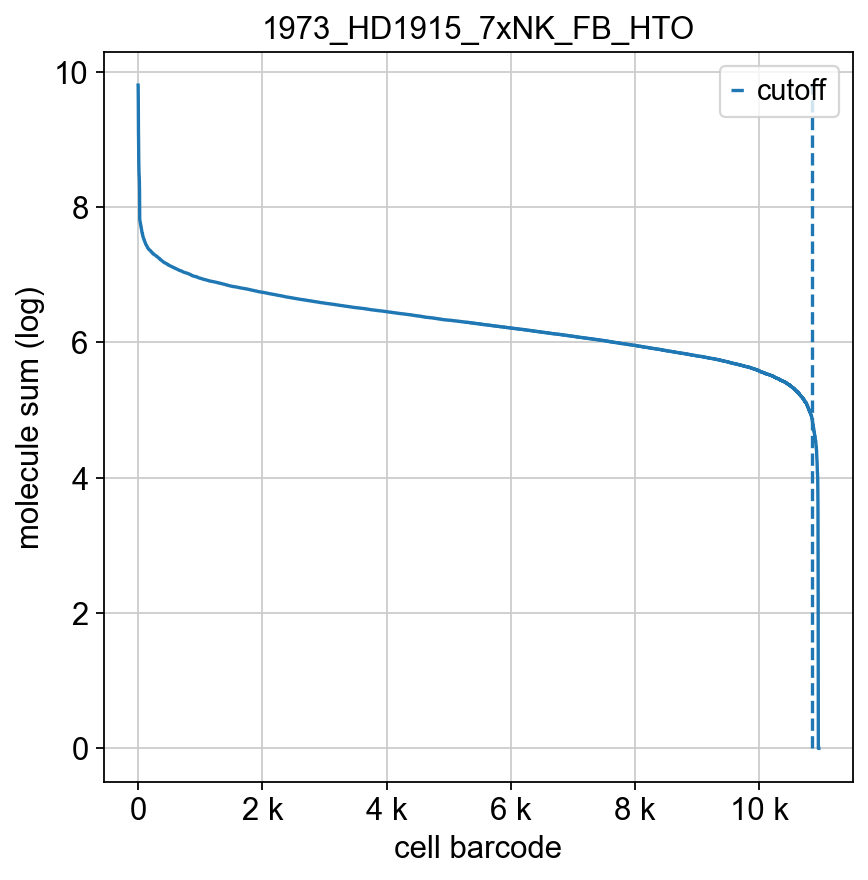

In [13]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

x = np.arange(0, adata_sorted.shape[0])
ms = np.log(adata_sorted.obs["total_umis"] + 1)
inflection_pts, d1, d2, ms2 = find_inflection_points(ms, 50, 50)
y_pred_poly, coeffs, intercept_poly = fit_polynomial(x, ms)
mse_poly = metrics.mean_squared_error(ms, y_pred_poly)
y_pred_linear, slope, intercept_linear = fit_linear(x, ms)

print(intercept_poly, mse_poly, slope)

if intercept_poly < 4:
    inflection_pt = inflection_pts[0]
elif intercept_poly < 5 and mse_poly >= 0.2:
    inflection_pt = inflection_pts[0]
else:
    if slope < -0.003:
        # fixme: we have no good inflection points
        inflection_pt = int(adata_sorted.shape[0] * 0.95)
    else:
        # 95% point
        inflection_pt = inflection_pts[int(len(inflection_pts)*0.99)]

ax.plot(range(0, adata_sorted.shape[0]), ms)
ax.vlines(
    x=inflection_pt,
    ymin=0,
    ymax=np.log(adata_sorted.obs["total_umis"].max()),
    linestyle='--', label="cutoff"
)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.xaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.set_title(sample_name)
ax.legend()

plt.show()

### Polynomial Regression

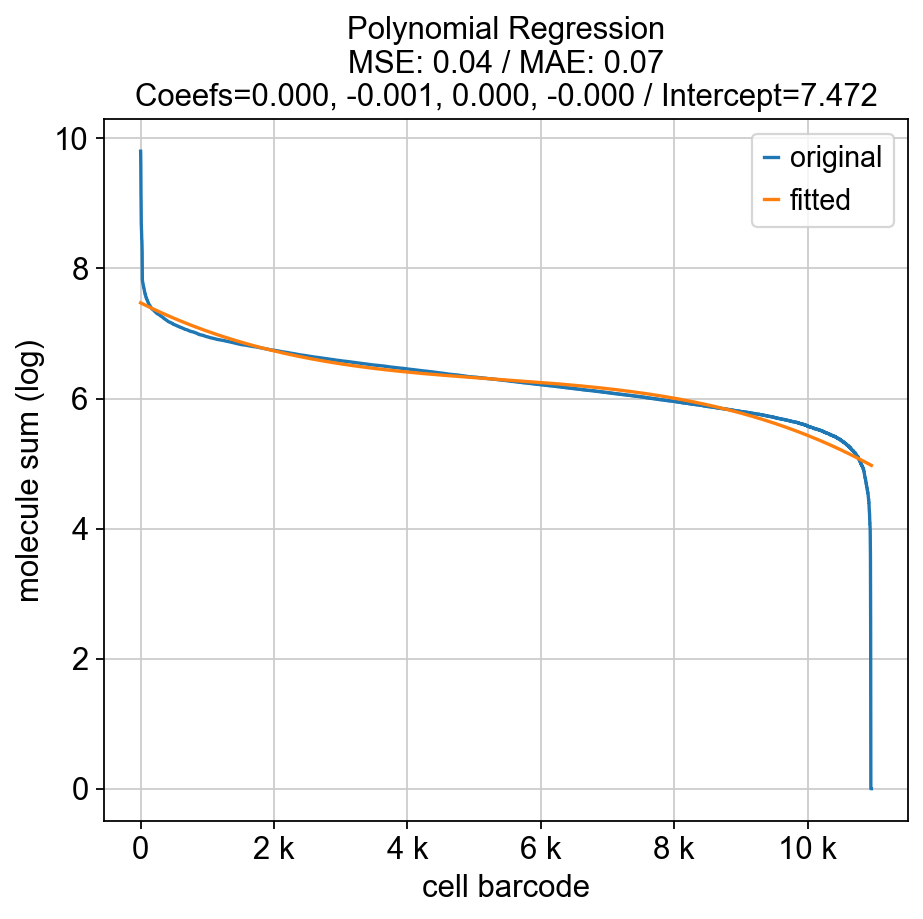

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

mse = metrics.mean_squared_error(ms, y_pred_poly)
mae = metrics.mean_absolute_error(ms, y_pred_poly)
ax.plot(x, ms, label="original")
ax.plot(x, y_pred_poly, label="fitted")
ax.set_title(
    "Polynomial Regression\n"
    "MSE: {0:.2f} / MAE: {1:.2f}\nCoeefs={2} / Intercept={3:.3f}".format(
        mse, mae, ", ".join(["{0:.3f}".format(x) for x in coeffs]), intercept_poly
    )    
)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.xaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.legend()

plt.tight_layout()
plt.show()

### Linear Regression

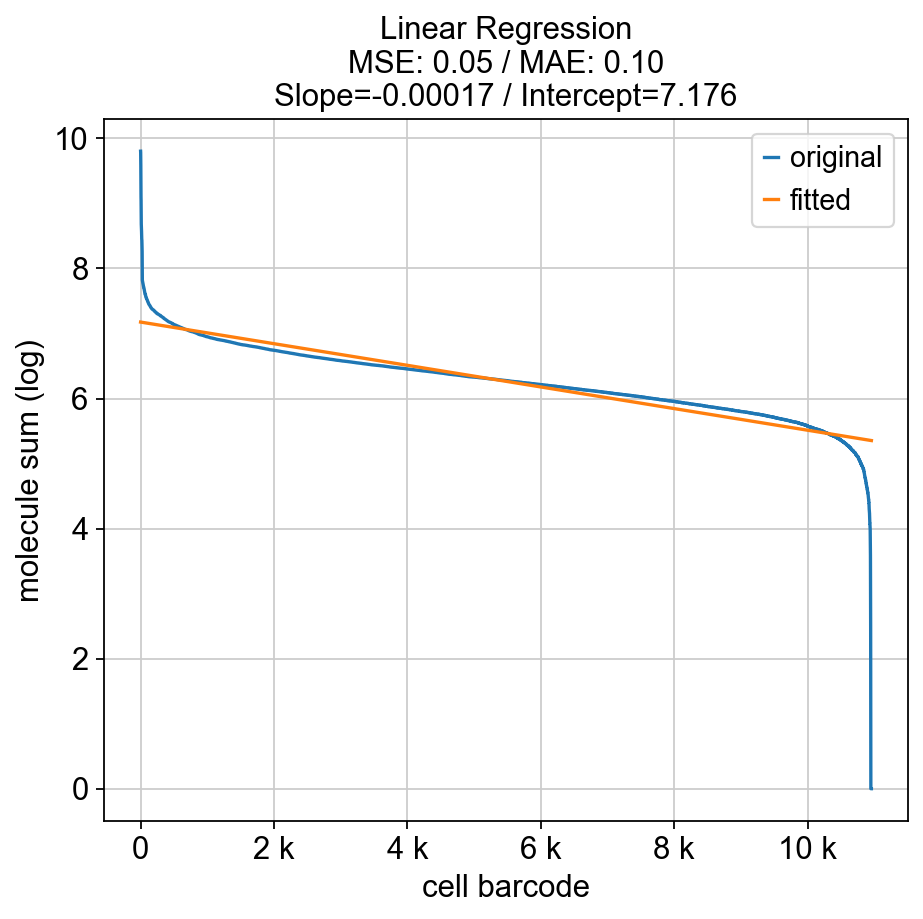

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

mse = metrics.mean_squared_error(ms, y_pred_linear)
mae = metrics.mean_absolute_error(ms, y_pred_linear)
ax.plot(x, ms, label="original")
ax.plot(x, y_pred_linear, label="fitted")
ax.set_title(
    "Linear Regression\n"
    "MSE: {0:.2f} / MAE: {1:.2f}\nSlope={2:.5f} / Intercept={3:.3f}".format(
        mse, mae, slope, intercept_linear
    )
)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.xaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.legend()

plt.tight_layout()
plt.show()

### Inflection Point

In [16]:
inflection_pt

10846

In [17]:
inflection_pts

array([10836, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10845,
       10846])

## KMeans to 3 Clusters

In [18]:
from sklearn.cluster import KMeans

### Find the Negative Cluster

In [19]:
# for those beyond the inflection point,
# use KMeans to group them into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=316)

In [20]:
X = adata_sorted[inflection_pt:].obs["total_umis"]
X

204198527223660    130
134945401334501    129
227982983157685    129
135132217753011    128
134954930294108    127
                  ... 
230677806501099      0
125238491630507      0
134513488743659      0
239460343532779      0
125238491662763      0
Name: total_umis, Length: 111, dtype: int64

In [21]:
y_predict = kmeans.fit_predict(X.values.reshape(-1, 1))

In [22]:
y_predict

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

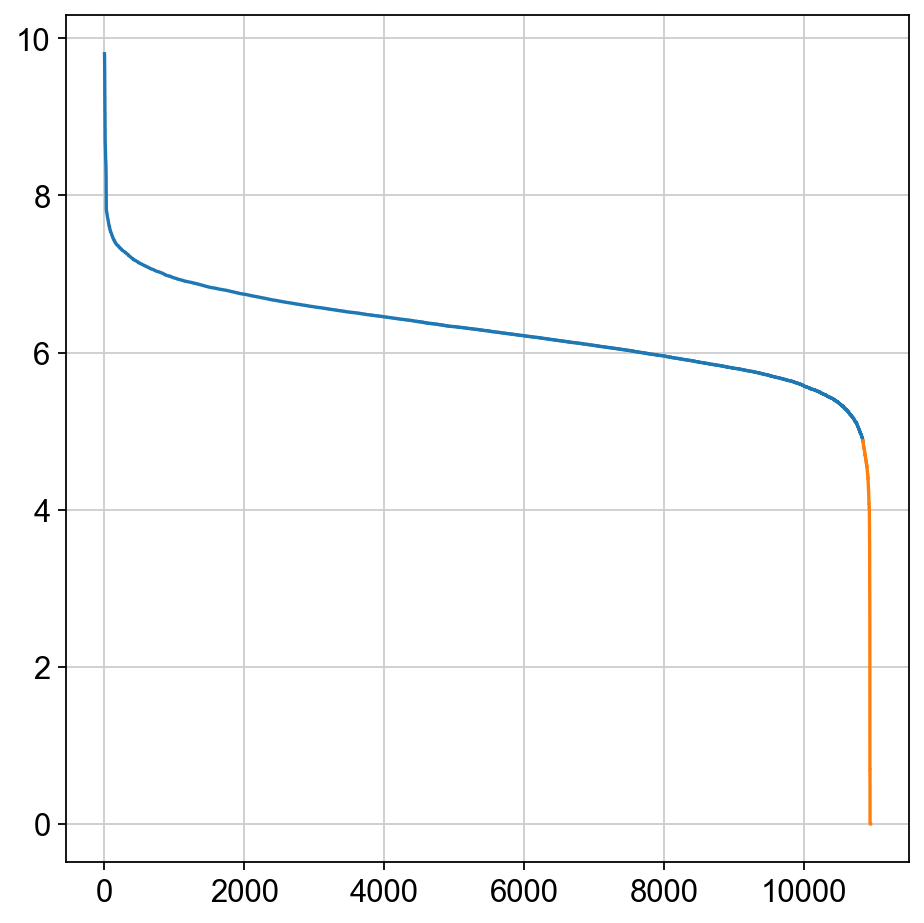

In [23]:
x = np.array(range(0, adata_sorted.shape[0]))
ms = np.log(adata_sorted.obs["total_umis"] + 1)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(x[:inflection_pt], ms[:inflection_pt])
ax.plot(x[inflection_pt:], ms[inflection_pt:])

plt.tight_layout()
plt.show()

In [24]:
np.diff(y_predict)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [25]:
# find break points (e.g. where 0s end and 1s begin)
breaks = np.where(np.diff(y_predict))[0] + 1
breaks

array([62, 95])

In [26]:
splits = np.split(adata_sorted[inflection_pt:].obs.total_umis.values, breaks)
splits

[array([130, 129, 129, 128, 127, 127, 125, 123, 123, 121, 121, 120, 120,
        120, 119, 119, 118, 117, 117, 117, 117, 116, 116, 115, 114, 113,
        113, 110, 110, 109, 109, 109, 108, 108, 106, 106, 106, 105, 105,
        104, 103, 103, 102, 101, 100, 100, 100, 100,  98,  98,  98,  97,
         96,  96,  95,  95,  94,  93,  93,  93,  93,  91]),
 array([89, 88, 88, 87, 86, 85, 85, 84, 84, 81, 81, 80, 80, 76, 75, 73, 72,
        70, 69, 69, 68, 65, 64, 61, 58, 58, 58, 55, 55, 54, 53, 47, 44]),
 array([36, 35, 21, 17, 11,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0])]

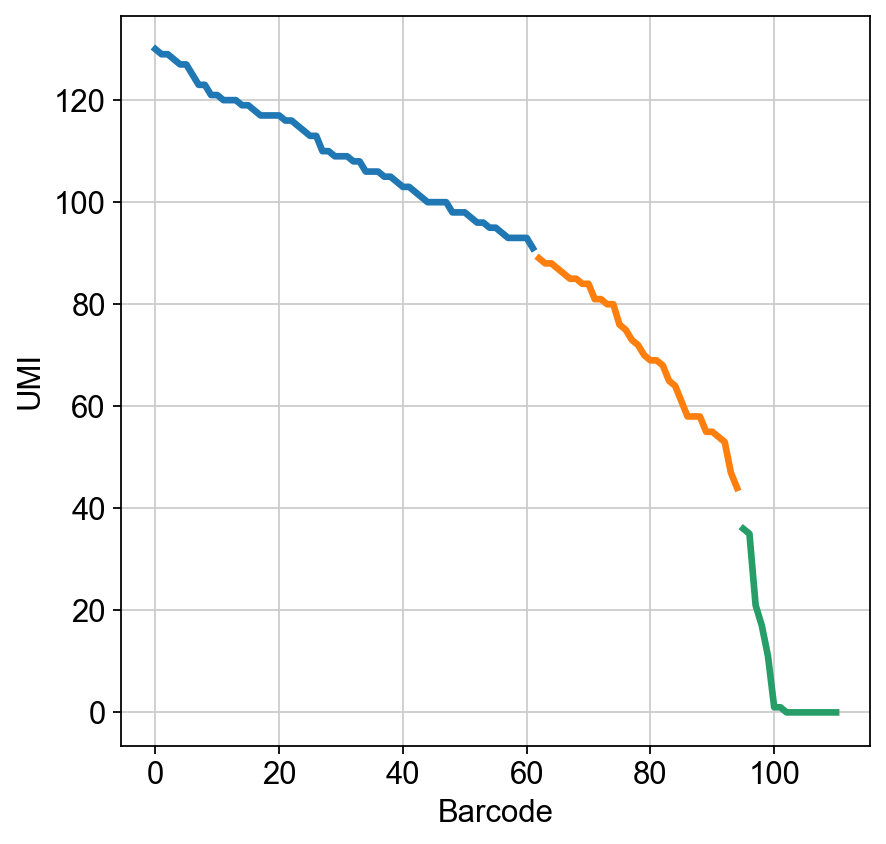

In [27]:
fig, ax = plt.subplots(figsize=(6,6))

n = 0
for cluster in range(len(splits)):
    ax.plot(
        np.arange(len(splits[cluster])) + (breaks[n - 1] if n > 0 else 0),
        splits[cluster],
        linewidth=3
    )
    n += 1

ax.set_ylabel("UMI")
ax.set_xlabel("Barcode")
    
plt.show()

In [28]:
# third cluster
breaks[-1]

95

In [29]:
# for new inflectin point
# choose the beginning of the last cluster (one with the least molecule counts) from the three clusters
inflection_pt = inflection_pt + breaks[-1]
inflection_pt

10941

In [30]:
# barcodes that belong to the chosen cluster
adata_sorted[inflection_pt:].obs

,unmapped,barcode_sequence,hash_id,total_umis
122436428123060,0,TTCGGTCTCTAAGCCA,A0253,36
226212233211229,0,CTTTCAATCTTCCGTG,A0255,35
204908283221805,3,GCAGCTGGTTGGTAGG,A0251,21
231282308437941,3,CAAGACTTCGAGTCCG,A0251,17
126682835925812,0,TACTTCAGTTCTGACA,A0255,11
122490786564902,0,TTCCTCTTCAAAGAAC,A0256,1
199807070756251,2,GGTTAACGTCTGCCTT,A0254,1
235214378491291,0,CGTCCATGTCTGCCTT,Doublet,0
125238492219116,0,TATCTGTTCGCATTGA,Doublet,0
125238491855662,0,TATCTGTTCATTGAGC,Doublet,0


In [31]:
adata_sorted[inflection_pt:].to_df()

,A0251-GTCAACTCTTTAGCG,A0252-TGATGGCCTATTGGG,A0253-TTCCGCCTCTCTTTG,A0254-AGTAAGTTCAGCGTA,A0255-AAGTATCGTTTCGCA,A0256-GGTTGCCAGATGTCA,A0257-TGTCTTTCCTGCCAG
122436428123060,0,1,34,1,0,0,0
226212233211229,0,0,0,0,35,0,0
204908283221805,17,0,1,3,0,0,0
231282308437941,14,0,0,2,0,1,0
126682835925812,0,0,0,0,11,0,0
122490786564902,0,0,0,0,0,1,0
199807070756251,0,0,0,1,0,0,0
235214378491291,0,0,0,0,0,0,0
125238492219116,0,0,0,0,0,0,0
125238491855662,0,0,0,0,0,0,0


### Mark as Negative

In [32]:
adata2 = adata_sorted.copy()

In [33]:
# duplicate, then later we will override if negatives are found
adata2.obs["hash_id2"] = adata2.obs["hash_id"]

In [34]:
adata2.obs.loc[adata2[inflection_pt:].obs_names]

,unmapped,barcode_sequence,hash_id,total_umis,hash_id2
122436428123060,0,TTCGGTCTCTAAGCCA,A0253,36,A0253
226212233211229,0,CTTTCAATCTTCCGTG,A0255,35,A0255
204908283221805,3,GCAGCTGGTTGGTAGG,A0251,21,A0251
231282308437941,3,CAAGACTTCGAGTCCG,A0251,17,A0251
126682835925812,0,TACTTCAGTTCTGACA,A0255,11,A0255
122490786564902,0,TTCCTCTTCAAAGAAC,A0256,1,A0256
199807070756251,2,GGTTAACGTCTGCCTT,A0254,1,A0254
235214378491291,0,CGTCCATGTCTGCCTT,Doublet,0,Doublet
125238492219116,0,TATCTGTTCGCATTGA,Doublet,0,Doublet
125238491855662,0,TATCTGTTCATTGAGC,Doublet,0,Doublet


In [35]:
# add a new category "Negative"
adata2.obs["hash_id"] = adata2.obs["hash_id"].cat.add_categories("Negative")
adata2.obs["hash_id2"] = adata2.obs["hash_id2"].cat.add_categories("Negative")

In [36]:
# anything after the inflection point found, we will mark them as Negative
adata2.obs.loc[adata2[inflection_pt:].obs_names, "hash_id2"] = "Negative"

In [37]:
adata2.obs

,unmapped,barcode_sequence,hash_id,total_umis,hash_id2
126268612721964,663,TAGGTACTCTGTCAGA,Doublet,18099,Doublet
231754935421741,656,CAGATCACACTAGAGG,Doublet,17741,Doublet
120703436111133,595,TTTATGCGTTGTCATG,Doublet,16239,Doublet
195554937355164,524,GATGGAGCAACTGCTA,Doublet,14573,Doublet
134585729570651,385,TCACTCGCACAGTGTT,A0254,10862,A0254
...,...,...,...,...,...
230677806501099,1,CATACTTAGGGACTGT,Doublet,0,Negative
125238491630507,0,TATCTGTTCTAAGCGT,Doublet,0,Negative
134513488743659,1,TCAGTTTAGGGACTGT,Doublet,0,Negative
239460343532779,1,CCTAACCAGGGACTGT,Doublet,0,Negative


### Final Results

#### Before

In [38]:
# before
adata2.obs.groupby("hash_id").size()

hash_id
A0251       1638
A0252       1135
A0253       2742
A0254       1007
A0255       1244
A0256       1295
A0257        874
Doublet     1022
Negative       0
dtype: int64

#### After

In [39]:
# after
adata2.obs.groupby("hash_id2").size()

hash_id2
A0251       1636
A0252       1135
A0253       2741
A0254       1006
A0255       1242
A0256       1294
A0257        874
Doublet     1013
Negative      16
dtype: int64

#### Differences

In [40]:
adata2_diff = adata2[ adata2.obs["hash_id"] != adata2.obs["hash_id2"] ]
adata2_diff.obs

,unmapped,barcode_sequence,hash_id,total_umis,hash_id2
122436428123060,0,TTCGGTCTCTAAGCCA,A0253,36,Negative
226212233211229,0,CTTTCAATCTTCCGTG,A0255,35,Negative
204908283221805,3,GCAGCTGGTTGGTAGG,A0251,21,Negative
231282308437941,3,CAAGACTTCGAGTCCG,A0251,17,Negative
126682835925812,0,TACTTCAGTTCTGACA,A0255,11,Negative
122490786564902,0,TTCCTCTTCAAAGAAC,A0256,1,Negative
199807070756251,2,GGTTAACGTCTGCCTT,A0254,1,Negative
235214378491291,0,CGTCCATGTCTGCCTT,Doublet,0,Negative
125238492219116,0,TATCTGTTCGCATTGA,Doublet,0,Negative
125238491855662,0,TATCTGTTCATTGAGC,Doublet,0,Negative


In [41]:
adata2_diff.obs.groupby(["hash_id", "hash_id2"]).size()

hash_id  hash_id2
A0251    Negative    2
A0253    Negative    1
A0254    Negative    1
A0255    Negative    2
A0256    Negative    1
Doublet  Negative    9
dtype: int64

## UMAP

In [42]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [43]:
adata2.raw = adata2

In [44]:
clr_normalize_each_cell(adata2)

AnnData object with n_obs × n_vars = 10957 × 7
    obs: 'unmapped', 'barcode_sequence', 'hash_id', 'total_umis', 'hash_id2'
    var: 'feature_name'

In [45]:
sc.pp.log1p(adata2)

In [46]:
sc.pp.neighbors(adata2)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [47]:
sc.tl.leiden(adata2, resolution=0.05, random_state=42)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [48]:
sc.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


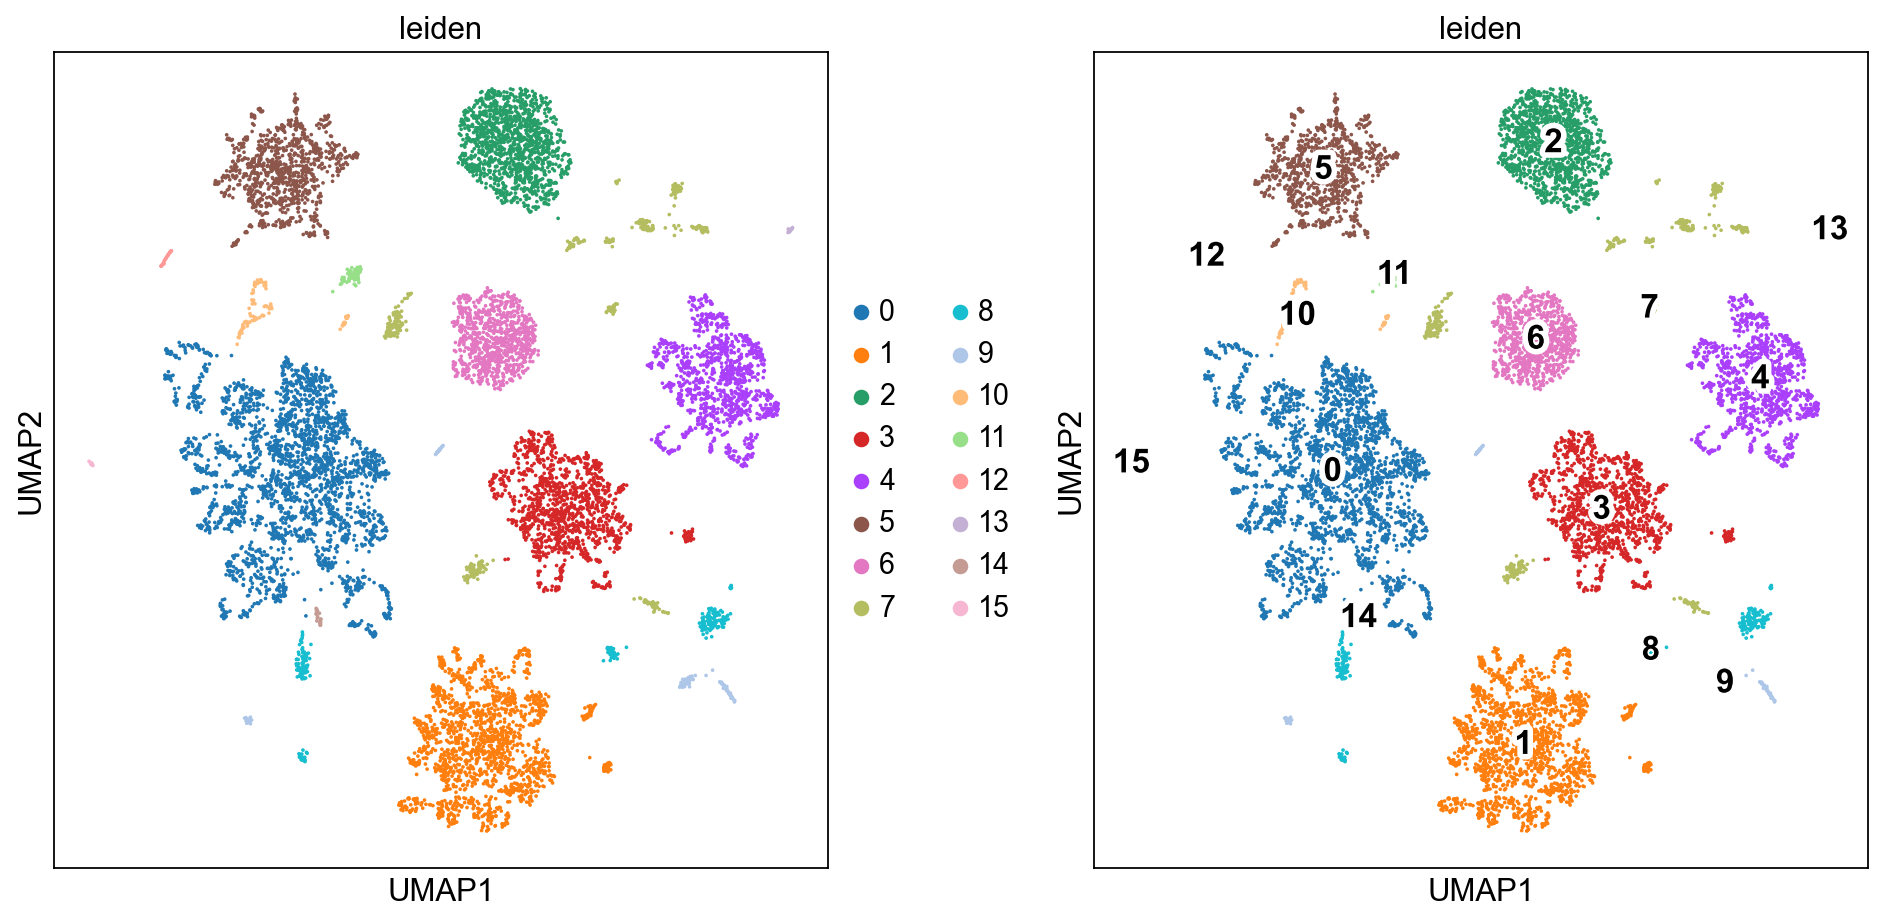

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["leiden"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["leiden"],
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

/Users/chunj/opt/miniconda3/envs/sharp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chunj/opt/miniconda3/envs/sharp/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values


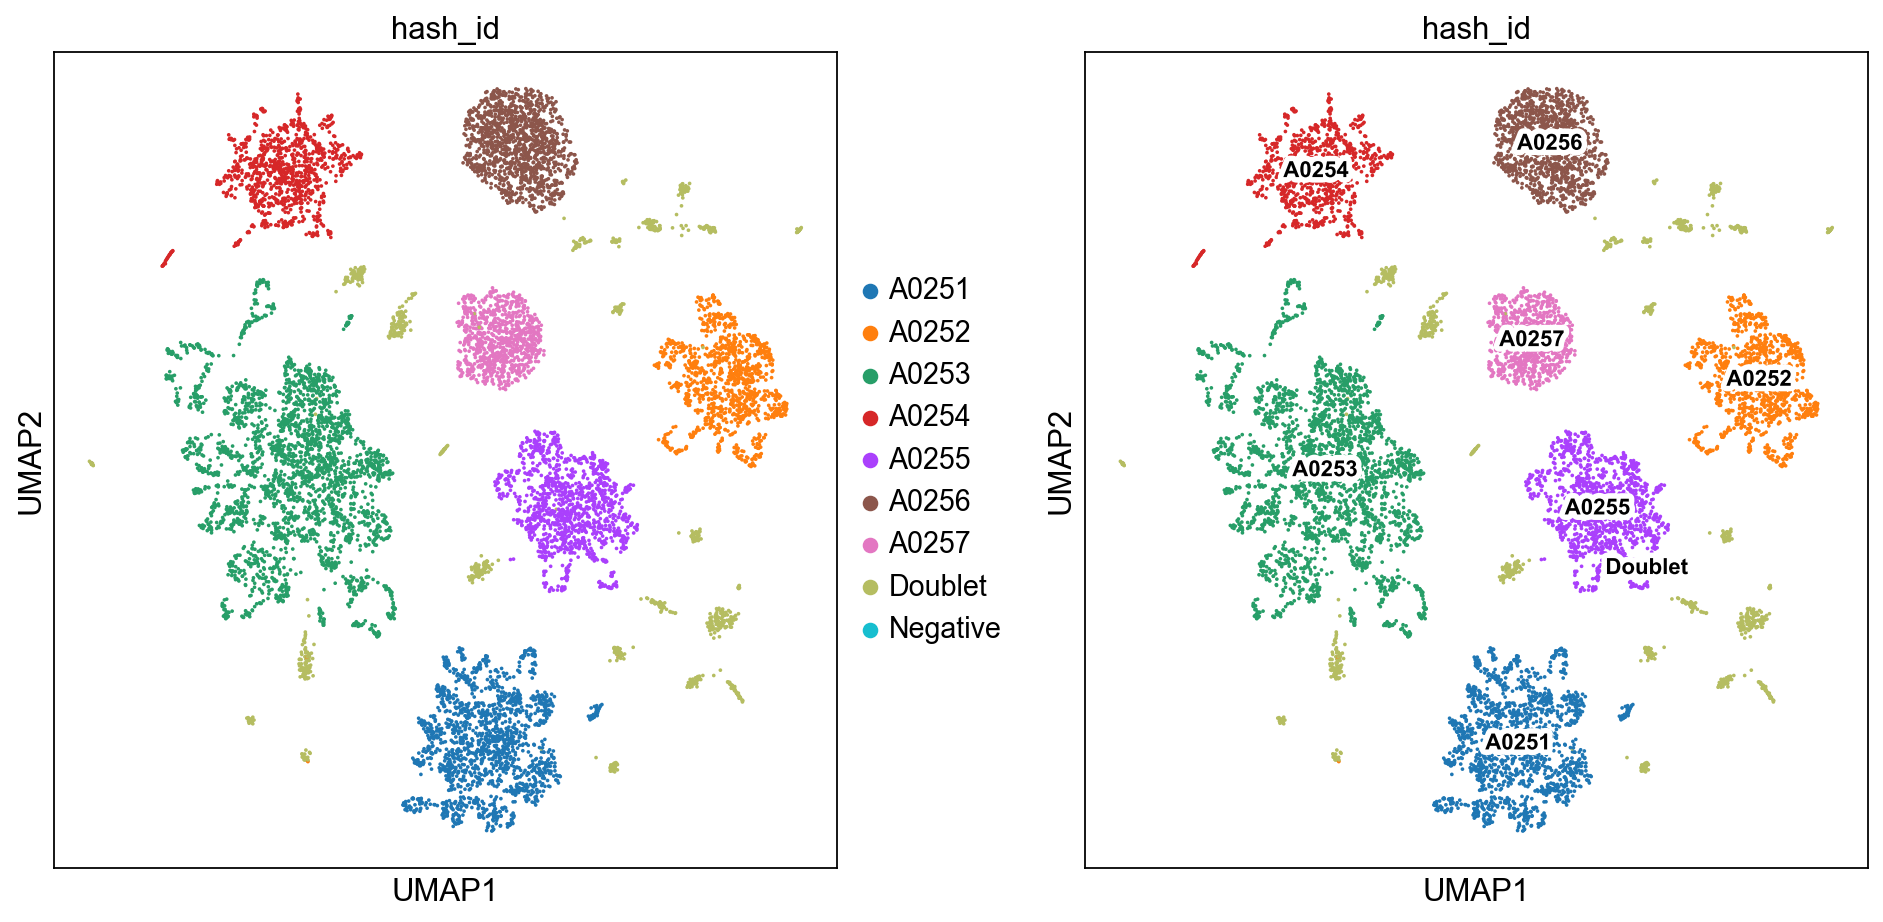

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["hash_id"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["hash_id"],
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

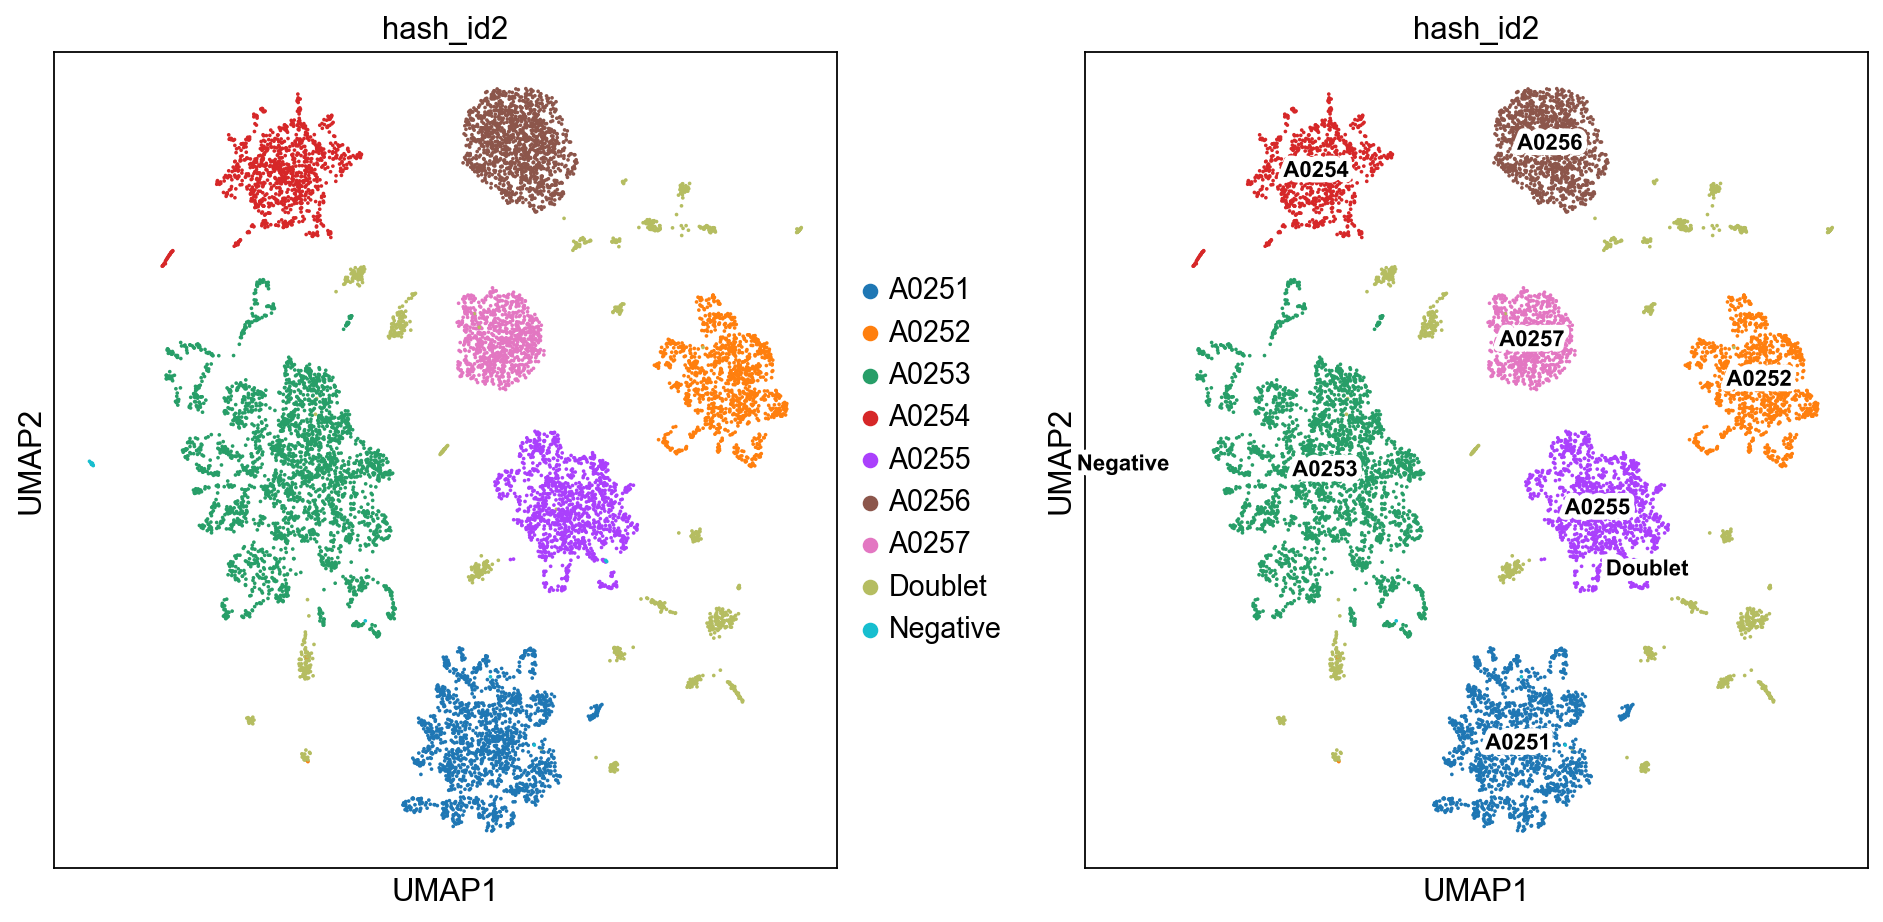

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata2,
    color=["hash_id2"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata2,
    color=["hash_id2"],
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

In [52]:
from matplotlib.colors import ListedColormap

my_cmap1 = ListedColormap(sns.color_palette("Blues").as_hex())
my_cmap2 = sns.color_palette("Paired").as_hex()
my_cmap2[0] = "lightgray"
my_cmap2 = ListedColormap(my_cmap2)

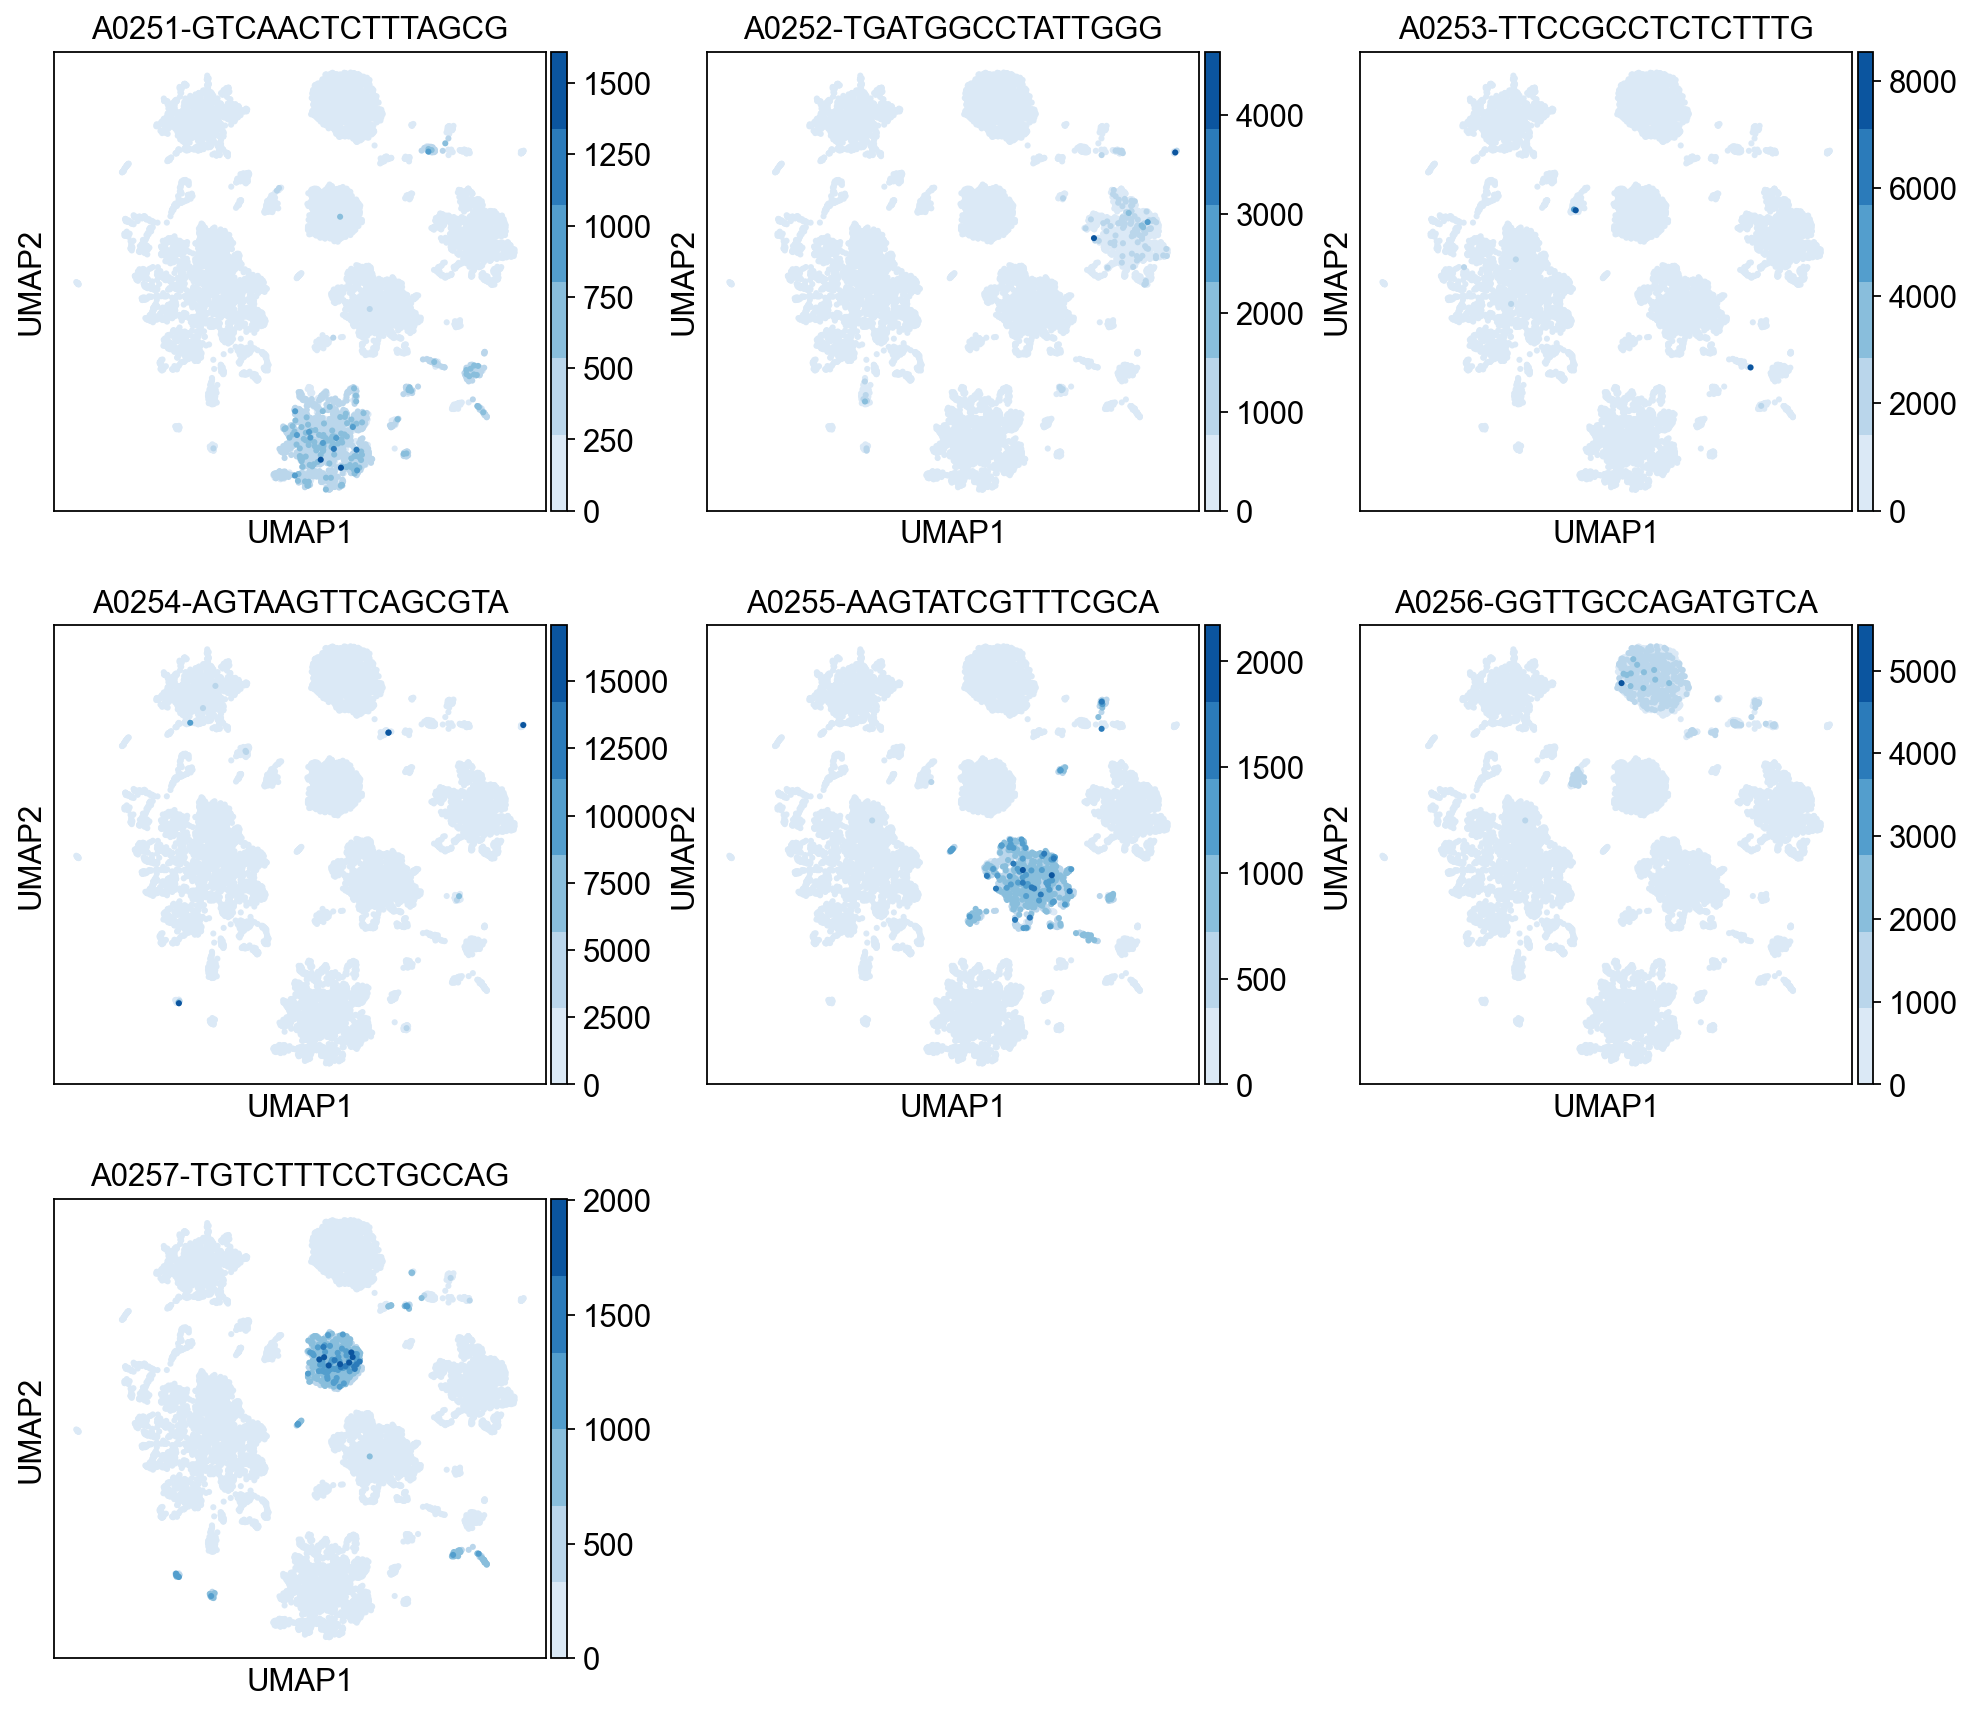

In [53]:
sc.pl.umap(
    adata2,
    color=adata2.var_names,
    color_map=my_cmap1,
    size=30,
    ncols=3,
)

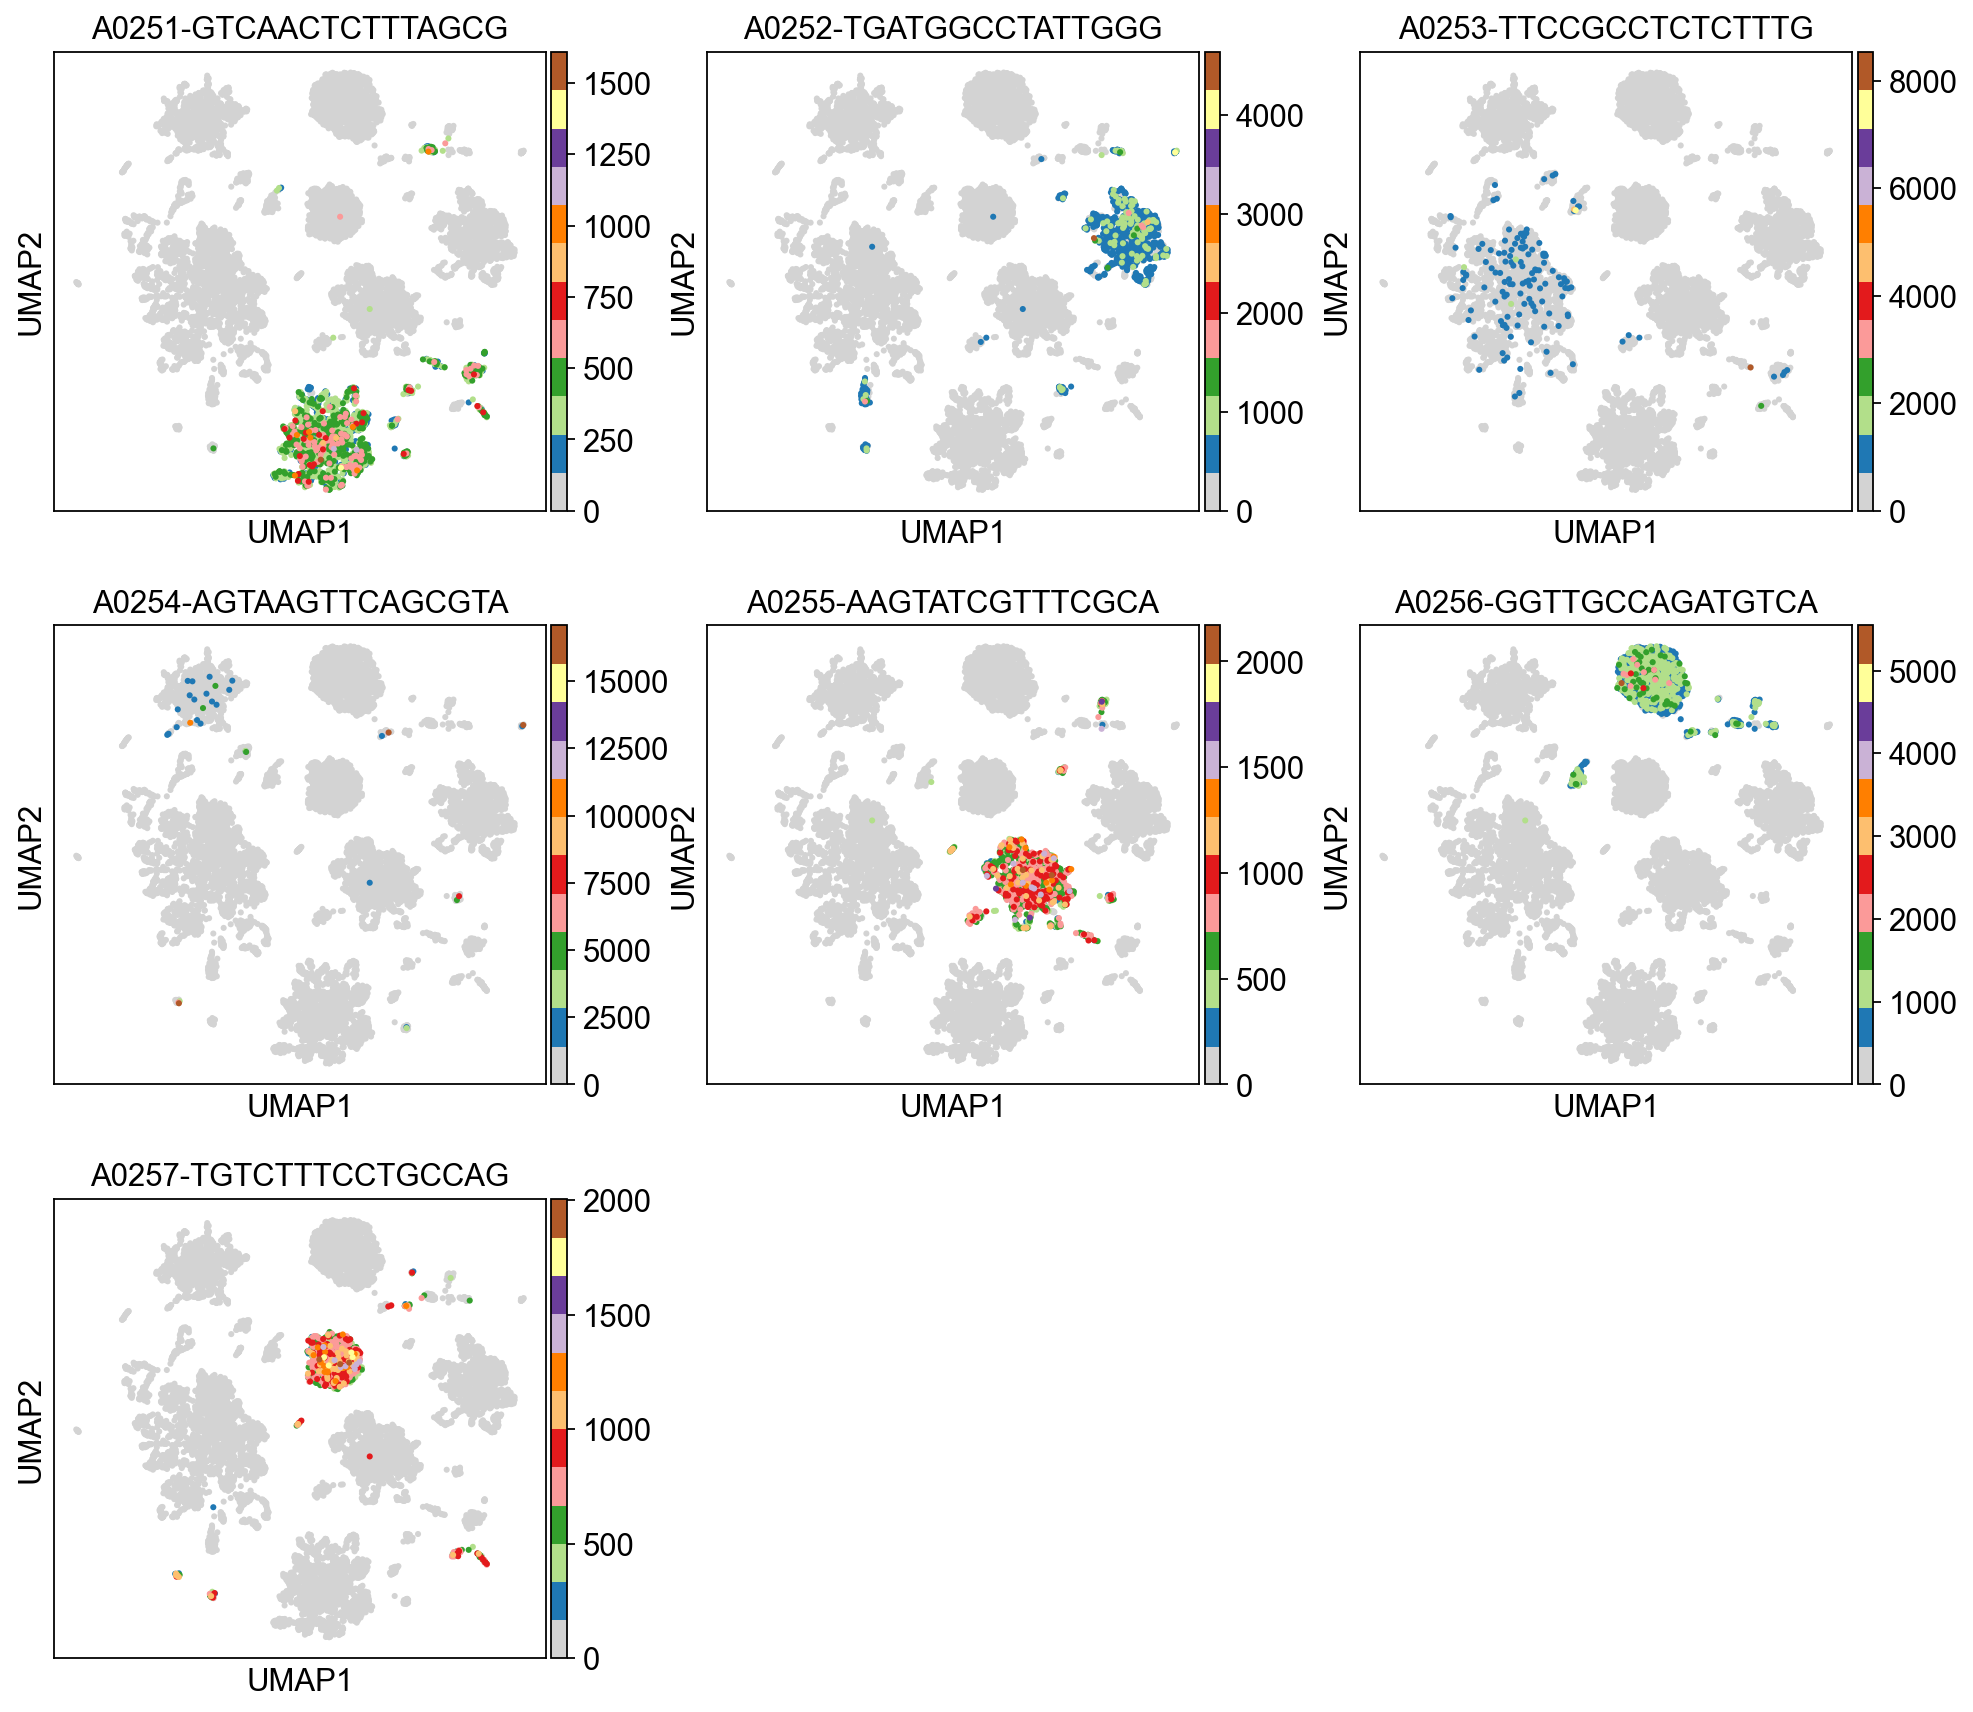

In [54]:
sc.pl.umap(
    adata2,
    color=adata2.var_names,
    color_map=my_cmap2,
    size=30,
    ncols=3,
)

## Write to Disk

In [55]:
adata2

AnnData object with n_obs × n_vars = 10957 × 7
    obs: 'unmapped', 'barcode_sequence', 'hash_id', 'total_umis', 'hash_id2', 'leiden'
    var: 'feature_name'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'hash_id_colors', 'hash_id2_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [56]:
adata2.write(os.path.join(path_data, f"{sample_name}.Negative.h5ad"))